In [1]:
import math
import random
import time
from typing import List, Literal

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import torch.nn.functional as F

%matplotlib inline

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using CUDA')
else:
    device = torch.device('cpu')
    print('Using CPU')

Using CUDA


In [3]:
TRAINING_STEPS = 10_000

In [4]:
RANDOM_SEED = 42
TORCH_GENERATOR_SEED = 2147483647

random.seed(RANDOM_SEED)
g = torch.Generator(device=device).manual_seed(TORCH_GENERATOR_SEED)

In [5]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
len(words)

32034

In [7]:
chars = sorted(list(set(str().join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [8]:
vocab_size = len(itos)
vocab_size

27

In [9]:
def build_dataset(words, block_size, device):
    X_data, Y_data = [], []
    for word in words:
        context = [0 for _ in range(block_size)]
        for ch in word + '.':
            ix = stoi[ch]

            X_data.append(context)
            Y_data.append(ix)

            context = context[1:] + [ix]

    X = torch.tensor(X_data, device=device)
    Y = torch.tensor(Y_data, device=device)
    return X, Y

In [10]:
block_size = 3

random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_tr, Y_tr = build_dataset(words[:n1], block_size, device)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size, device)
X_te, Y_te = build_dataset(words[n2:], block_size, device)

print(f'{X_tr.shape=}, {Y_tr.shape=}\n{X_dev.shape=}, {Y_dev.shape=}\n{X_te.shape=}, {Y_te.shape=}')

X_tr.shape=torch.Size([182620, 3]), Y_tr.shape=torch.Size([182620])
X_dev.shape=torch.Size([22664, 3]), Y_dev.shape=torch.Size([22664])
X_te.shape=torch.Size([22869, 3]), Y_te.shape=torch.Size([22869])


In [11]:
from abc import ABC, abstractmethod

class Layer(ABC):
    out: Tensor | None

    @abstractmethod
    def parameters() -> List[Tensor]:
        pass

In [12]:
class Linear(Layer):

    def __init__(self, fan_in, fan_out, bias=True, generator=None, device=None):
        self.weight = torch.randn((fan_in, fan_out), generator=generator, device=device) / torch.sqrt(torch.tensor(fan_in)).item()
        self.bias = torch.zeros(fan_out, device=device) if bias else None

    def __call__(self, x: Tensor):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [13]:
class BatchNorm1d(Layer):

    def __init__(self, dim, eps=1e-5, momentum=0.1, device=None):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim, device=device)
        self.beta = torch.zeros(dim, device=device)
        self.running_mean = torch.zeros(dim, device=device)
        self.running_var = torch.ones(dim, device=device)

    def __call__(self, x: Tensor):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [14]:
class Tanh(Layer):

    def __call__(self, x: Tensor):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [15]:
class Embedding(Layer):

    def __init__(self, num_embeddings, embedding_dim, generator = None, device = None):
        self.weight = torch.randn((num_embeddings, embedding_dim), generator=generator, device=device)

    def __call__(self, ix: Tensor) -> Tensor:
        self.out = self.weight[ix]
        return self.out

    def parameters(self) -> List[Tensor]:
        return [self.weight]

In [16]:
class Flatten(Layer):

    def __call__(self, x: Tensor):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self) -> List[Tensor]:
        return []

In [17]:
n_embd = 10
n_hidden = 200

g = torch.Generator(device=device).manual_seed(TORCH_GENERATOR_SEED)
C = torch.randn((vocab_size, n_embd), generator=g, device=device)

layers: List[Layer] = [
    Linear(n_embd * block_size, n_hidden, bias=False, generator=g, device=device),
    BatchNorm1d(n_hidden, device=device),
    Tanh(),
    Linear(n_hidden, vocab_size, generator=g, device=device)
]

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True
print(f'Number of parameters: {sum(p.nelement() for p in parameters)}')

Number of parameters: 12097


In [18]:
def train(layers: List[Layer], C: Tensor, X_tr: Tensor, Y_tr: Tensor, lr = 0.01, max_steps = 200_000, batch_size=32, generator=None, device=None):
    lossi = []
    ud = []
    for i in range(max_steps):
        ix = torch.randint(0, X_tr.shape[0], (batch_size,), generator=generator, device=device)
        Xb, Yb = X_tr[ix], Y_tr[ix]

        emb = C[Xb]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb)

        for layer in layers:
            if layer.out is not None:
                layer.out.retain_grad()
        for p in parameters:
            p.grad = None
        loss.backward()

        lr = lr if i < max_steps / 2 else 0.01
        for p in parameters:
            p.data += -lr * p.grad

        if max_steps < 25 or i % int(max_steps / 25) == 0:
            print(f'Iteration: {i}/{max_steps}, Loss: {loss.item():.4f}')

        lossi.append(loss.log10())

        with torch.no_grad():
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    return layers, lossi, ud

In [19]:
layers, lossi, ud = train(layers, C, X_tr, Y_tr, max_steps=TRAINING_STEPS, lr=0.1, generator=g, device=device)

Iteration: 0/10000, Loss: 3.2933
Iteration: 400/10000, Loss: 2.6315
Iteration: 800/10000, Loss: 2.4377
Iteration: 1200/10000, Loss: 2.2282
Iteration: 1600/10000, Loss: 2.5048
Iteration: 2000/10000, Loss: 2.2860
Iteration: 2400/10000, Loss: 2.5616
Iteration: 2800/10000, Loss: 2.3106
Iteration: 3200/10000, Loss: 2.2955
Iteration: 3600/10000, Loss: 1.9811
Iteration: 4000/10000, Loss: 2.1862
Iteration: 4400/10000, Loss: 2.3380
Iteration: 4800/10000, Loss: 2.4798
Iteration: 5200/10000, Loss: 2.1373
Iteration: 5600/10000, Loss: 2.4296
Iteration: 6000/10000, Loss: 2.4204
Iteration: 6400/10000, Loss: 2.3689
Iteration: 6800/10000, Loss: 2.2352
Iteration: 7200/10000, Loss: 2.3575
Iteration: 7600/10000, Loss: 2.3710
Iteration: 8000/10000, Loss: 2.1628
Iteration: 8400/10000, Loss: 2.1659
Iteration: 8800/10000, Loss: 2.3149
Iteration: 9200/10000, Loss: 2.7151
Iteration: 9600/10000, Loss: 2.0900


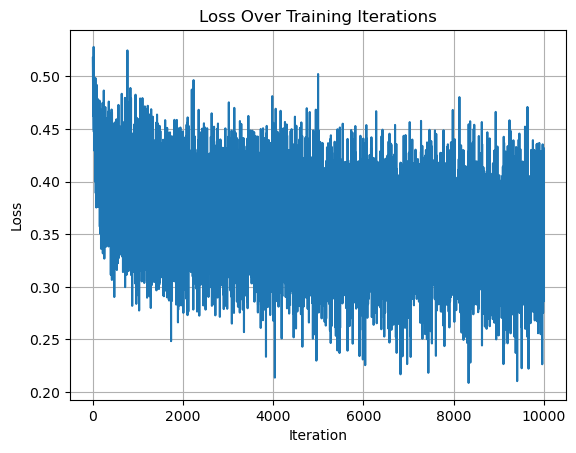

In [20]:
lossi_cpu = [l.item() for l in lossi]
plt.figure()
plt.plot(lossi_cpu)
plt.title('Loss Over Training Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [21]:
for layer in layers:
    layer.training = False

In [22]:
@torch.no_grad()
def loss_of_split(split: Literal['train'] | Literal['test'] | Literal['val'], layers: List[Layer]):
    x, y = {
        'train': (X_tr, Y_tr),
        'val': (X_dev, Y_dev),
        'test': (X_te, Y_te)
    }[split]

    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)

    print(f'Loss of \'{split}\' split: {loss.item():.4f}')

In [23]:
loss_of_split('train', layers)
loss_of_split('val', layers)

Loss of 'train' split: 2.2221
Loss of 'val' split: 2.2310


In [24]:
g = torch.Generator(device=device).manual_seed(TORCH_GENERATOR_SEED + 105)

for _ in range(20):
    out = []
    context = [0 for _ in range(block_size)]

    while True:
        context_tensor = torch.tensor([context], device=device)

        emb = C[context_tensor]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print(str().join(itos[i] for i in out))

ry.
triger.
mire.
cist.
yah.
sharlyn.
lec.
ash.
dedhanazrk.
khanni.
ja.
oluwan.
ne.
ellie.
ron.
myl.
jee.
karsae.
urar.
ayline.


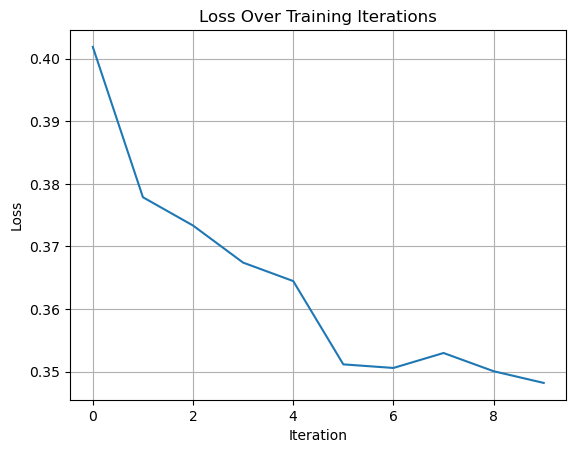

In [25]:
lossi_tensor = torch.tensor(lossi, device=device)
plt.figure()
plt.plot(lossi_tensor.view(-1, 1000).mean(1).cpu())
plt.title('Loss Over Training Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [26]:
class Sequential:

    def __init__(self, layers: List[Layer]):
        self.layers = layers

    def __call__(self, x: Tensor) -> Tensor:
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self) -> List[Tensor]:
        return [p for layer in self.layers for p in layer.parameters()]

In [27]:
n_embd = 10
n_hidden = 200

g = torch.Generator(device=device).manual_seed(TORCH_GENERATOR_SEED)

model = Sequential([
    Embedding(vocab_size, n_embd, generator=g, device=device),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False, generator=g, device=device),
    BatchNorm1d(n_hidden, device=device),
    Tanh(),
    Linear(n_hidden, vocab_size, generator=g, device=device)
])

with torch.no_grad():
    layers[-1].weight *= 0.1

for p in model.parameters():
    p.requires_grad = True
print(f'Number of parameters: {sum(p.nelement() for p in model.parameters())}')

Number of parameters: 12097


In [28]:
def train(model: Sequential, C: Tensor, X_tr: Tensor, Y_tr: Tensor, lr = 0.01, max_steps = 200_000, batch_size=32, generator=None, device=None):
    lossi = []
    ud = []
    for i in range(max_steps):
        ix = torch.randint(0, X_tr.shape[0], (batch_size,), generator=generator, device=device)
        Xb, Yb = X_tr[ix], Y_tr[ix]

        logits = model(Xb)
        loss = F.cross_entropy(logits, Yb)

        for layer in model.layers:
            if layer.out is not None:
                layer.out.retain_grad()
        for p in model.parameters():
            p.grad = None
        loss.backward()

        lr = lr if i < max_steps / 2 else lr / 10
        for p in model.parameters():
            p.data += -lr * p.grad

        if max_steps < 25 or i % int(max_steps / 25) == 0:
            print(f'Iteration: {i}/{max_steps}, Loss: {loss.item():.4f}')

        lossi.append(loss.log10())

        with torch.no_grad():
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in model.parameters()])

    return model, lossi, ud

In [29]:
model, lossi, ud = train(model, C, X_tr, Y_tr, max_steps=TRAINING_STEPS, lr=0.1, generator=g, device=device)

Iteration: 0/10000, Loss: 3.4521
Iteration: 400/10000, Loss: 2.5758
Iteration: 800/10000, Loss: 2.4437
Iteration: 1200/10000, Loss: 2.1994
Iteration: 1600/10000, Loss: 2.5093
Iteration: 2000/10000, Loss: 2.2985
Iteration: 2400/10000, Loss: 2.5499
Iteration: 2800/10000, Loss: 2.3200
Iteration: 3200/10000, Loss: 2.2357
Iteration: 3600/10000, Loss: 1.9933
Iteration: 4000/10000, Loss: 2.1524
Iteration: 4400/10000, Loss: 2.2831
Iteration: 4800/10000, Loss: 2.5153
Iteration: 5200/10000, Loss: 2.2134
Iteration: 5600/10000, Loss: 2.4017
Iteration: 6000/10000, Loss: 2.3431
Iteration: 6400/10000, Loss: 2.3794
Iteration: 6800/10000, Loss: 2.3468
Iteration: 7200/10000, Loss: 2.4159
Iteration: 7600/10000, Loss: 2.3267
Iteration: 8000/10000, Loss: 2.3704
Iteration: 8400/10000, Loss: 2.2850
Iteration: 8800/10000, Loss: 2.2503
Iteration: 9200/10000, Loss: 2.8121
Iteration: 9600/10000, Loss: 2.1575


In [30]:
@torch.no_grad()
def loss_of_split(split: Literal['train'] | Literal['test'] | Literal['val'], model: Sequential):
    x, y = {
        'train': (X_tr, Y_tr),
        'val': (X_dev, Y_dev),
        'test': (X_te, Y_te)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)

    print(f'Loss of \'{split}\' split: {loss.item():.4f}')

In [31]:
def generate(model: Sequential, number_of_names: int, block_size: int, generator = None, device = None) -> None:
    for _ in range(number_of_names):
        out = []
        context = [0 for _ in range(block_size)]

        while True:
            context_tensor = torch.tensor([context], device=device)

            logits = model(context_tensor)
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()

            context = context[1:] + [ix]
            out.append(ix)

            if ix == 0:
                break

        print(str().join(itos[i] for i in out))

In [32]:
for layer in model.layers:
    layer.training = False

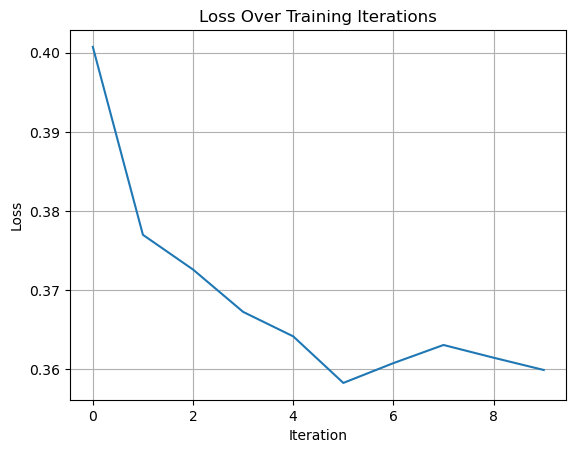

In [33]:
lossi_tensor = torch.tensor(lossi, device=device)
plt.figure()
plt.plot(lossi_tensor.view(-1, 1000).mean(1).cpu())
plt.title('Loss Over Training Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [34]:
loss_of_split('train', model)
loss_of_split('val', model)

Loss of 'train' split: 2.2854
Loss of 'val' split: 2.2969


In [35]:
g = torch.Generator(device=device).manual_seed(TORCH_GENERATOR_SEED + 105)
generate(model, 20, block_size, generator=g, device=device)

hy.
trigen.
mire.
cia.
gylin.
ctilaalin.
rosi.
nudeanazra.
khannie.
g.
oluwan.
nia.
lenem.
ynemyl.
jee.
greste.
urar.
yya.
meic.
maria.


In [36]:
block_size = 8

random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_tr, Y_tr = build_dataset(words[:n1], block_size, device)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size, device)
X_te, Y_te = build_dataset(words[n2:], block_size, device)

print(f'{X_tr.shape=}, {Y_tr.shape=}\n{X_dev.shape=}, {Y_dev.shape=}\n{X_te.shape=}, {Y_te.shape=}')

X_tr.shape=torch.Size([182477, 8]), Y_tr.shape=torch.Size([182477])
X_dev.shape=torch.Size([22854, 8]), Y_dev.shape=torch.Size([22854])
X_te.shape=torch.Size([22822, 8]), Y_te.shape=torch.Size([22822])


In [37]:
n_embd = 10
n_hidden = 200

g = torch.Generator(device=device).manual_seed(TORCH_GENERATOR_SEED)

model = Sequential([
    Embedding(vocab_size, n_embd, generator=g, device=device),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False, generator=g, device=device),
    BatchNorm1d(n_hidden, device=device),
    Tanh(),
    Linear(n_hidden, vocab_size, generator=g, device=device)
])

with torch.no_grad():
    layers[-1].weight *= 0.1

for p in model.parameters():
    p.requires_grad = True
print(f'Number of parameters: {sum(p.nelement() for p in model.parameters())}')

Number of parameters: 22097


In [38]:
model, lossi, ud = train(model, C, X_tr, Y_tr, max_steps=TRAINING_STEPS, lr=0.1, generator=g, device=device)

Iteration: 0/10000, Loss: 3.5835
Iteration: 400/10000, Loss: 2.3818
Iteration: 800/10000, Loss: 2.4318
Iteration: 1200/10000, Loss: 2.4835
Iteration: 1600/10000, Loss: 2.6323
Iteration: 2000/10000, Loss: 2.3928
Iteration: 2400/10000, Loss: 2.1230
Iteration: 2800/10000, Loss: 2.3132
Iteration: 3200/10000, Loss: 2.2332
Iteration: 3600/10000, Loss: 2.2308
Iteration: 4000/10000, Loss: 2.6740
Iteration: 4400/10000, Loss: 2.0328
Iteration: 4800/10000, Loss: 2.1251
Iteration: 5200/10000, Loss: 2.5212
Iteration: 5600/10000, Loss: 2.2447
Iteration: 6000/10000, Loss: 2.6679
Iteration: 6400/10000, Loss: 2.5799
Iteration: 6800/10000, Loss: 2.3230
Iteration: 7200/10000, Loss: 2.6698
Iteration: 7600/10000, Loss: 2.2492
Iteration: 8000/10000, Loss: 1.7497
Iteration: 8400/10000, Loss: 2.3005
Iteration: 8800/10000, Loss: 1.9513
Iteration: 9200/10000, Loss: 2.6671
Iteration: 9600/10000, Loss: 2.3957


In [39]:
for layer in model.layers:
    print(f'Layer: {layer.__class__.__name__}, Shape: {tuple(layer.out.shape)}')

Layer: Embedding, Shape: (32, 8, 10)
Layer: Flatten, Shape: (32, 80)
Layer: Linear, Shape: (32, 200)
Layer: BatchNorm1d, Shape: (32, 200)
Layer: Tanh, Shape: (32, 200)
Layer: Linear, Shape: (32, 27)


In [40]:
for layer in model.layers:
    layer.training = False

In [41]:
loss_of_split('train', model)
loss_of_split('val', model)

Loss of 'train' split: 2.2518
Loss of 'val' split: 2.2763


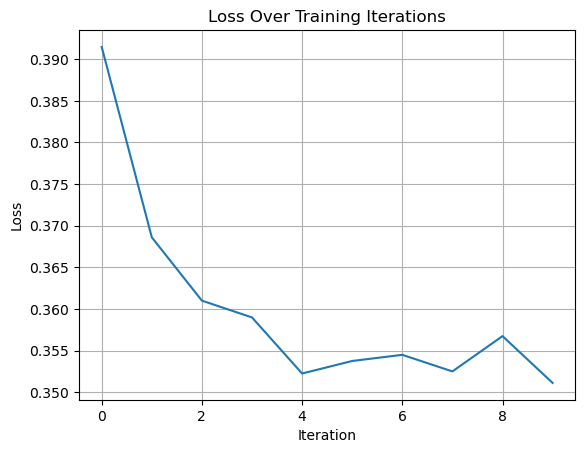

In [42]:
lossi_tensor = torch.tensor(lossi, device=device)
plt.figure()
plt.plot(lossi_tensor.view(-1, 1000).mean(1).cpu())
plt.title('Loss Over Training Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [43]:
g = torch.Generator(device=device).manual_seed(TORCH_GENERATOR_SEED + 105)
generate(model, 20, block_size, generator=g, device=device)

ryatreg.
farlyn.
cisteyn.
chatrlyn.
licen.
janden.
lozen.
khanni.
janoi.
braste.
elenem.
animya.
jeen.
jasee.
urarey.
damer.
kicjan.
lorinn.
kreler.
karetton.


In [44]:
class FlattenConsecutive(Layer):

    def __init__(self, n: int):
        self.n = n

    def __call__(self, x: Tensor):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self) -> List[Tensor]:
        return []

In [45]:
n_embd = 10
n_hidden = 200

g = torch.Generator(device=device).manual_seed(TORCH_GENERATOR_SEED)

model = Sequential([
    Embedding(vocab_size, n_embd, generator=g, device=device),
    FlattenConsecutive(2),
    Linear(n_embd * 2, n_hidden, bias=False, generator=g, device=device),
    BatchNorm1d(n_hidden, device=device),
    Tanh(),
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias=False, generator=g, device=device),
    BatchNorm1d(n_hidden, device=device),
    Tanh(),
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias=False, generator=g, device=device),
    BatchNorm1d(n_hidden, device=device),
    Tanh(),
    Linear(n_hidden, vocab_size, generator=g, device=device)
])

with torch.no_grad():
    layers[-1].weight *= 0.1

for p in model.parameters():
    p.requires_grad = True
print(f'Number of parameters: {sum(p.nelement() for p in model.parameters())}')

Number of parameters: 170897


In [46]:
model, lossi, ud = train(model, C, X_tr, Y_tr, max_steps=TRAINING_STEPS, lr=0.1, generator=g, device=device)

Iteration: 0/10000, Loss: 3.4699
Iteration: 400/10000, Loss: 2.6812
Iteration: 800/10000, Loss: 2.3461
Iteration: 1200/10000, Loss: 2.6891
Iteration: 1600/10000, Loss: 2.4771
Iteration: 2000/10000, Loss: 2.1646
Iteration: 2400/10000, Loss: 2.0916
Iteration: 2800/10000, Loss: 1.9738
Iteration: 3200/10000, Loss: 2.2913
Iteration: 3600/10000, Loss: 2.2251
Iteration: 4000/10000, Loss: 2.0587
Iteration: 4400/10000, Loss: 2.1598
Iteration: 4800/10000, Loss: 2.7893
Iteration: 5200/10000, Loss: 1.9576
Iteration: 5600/10000, Loss: 2.3871
Iteration: 6000/10000, Loss: 2.1031
Iteration: 6400/10000, Loss: 2.6968
Iteration: 6800/10000, Loss: 2.2583
Iteration: 7200/10000, Loss: 2.1667
Iteration: 7600/10000, Loss: 2.2325
Iteration: 8000/10000, Loss: 2.3893
Iteration: 8400/10000, Loss: 2.2697
Iteration: 8800/10000, Loss: 1.9434
Iteration: 9200/10000, Loss: 2.4022
Iteration: 9600/10000, Loss: 2.4192


In [47]:
for layer in model.layers:
    print(f'Layer: {layer.__class__.__name__}, Shape: {tuple(layer.out.shape)}')

Layer: Embedding, Shape: (32, 8, 10)
Layer: FlattenConsecutive, Shape: (32, 4, 20)
Layer: Linear, Shape: (32, 4, 200)
Layer: BatchNorm1d, Shape: (32, 4, 200)
Layer: Tanh, Shape: (32, 4, 200)
Layer: FlattenConsecutive, Shape: (32, 2, 400)
Layer: Linear, Shape: (32, 2, 200)
Layer: BatchNorm1d, Shape: (32, 2, 200)
Layer: Tanh, Shape: (32, 2, 200)
Layer: FlattenConsecutive, Shape: (32, 400)
Layer: Linear, Shape: (32, 200)
Layer: BatchNorm1d, Shape: (32, 200)
Layer: Tanh, Shape: (32, 200)
Layer: Linear, Shape: (32, 27)


In [48]:
for layer in model.layers:
    layer.training = False

In [49]:
loss_of_split('train', model)
loss_of_split('val', model)

Loss of 'train' split: 2.2100
Loss of 'val' split: 2.2395


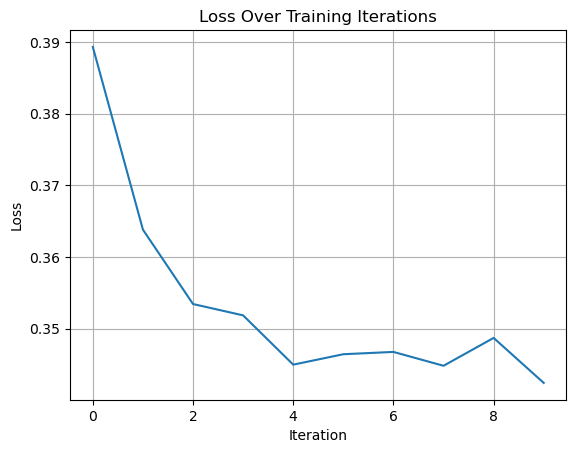

In [50]:
lossi_tensor = torch.tensor(lossi, device=device)
plt.figure()
plt.plot(lossi_tensor.view(-1, 1000).mean(1).cpu())
plt.title('Loss Over Training Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [51]:
g = torch.Generator(device=device).manual_seed(TORCH_GENERATOR_SEED + 105)
generate(model, 20, block_size, generator=g, device=device)

ryrtreg.
farlyn.
cisteyn.
chrtilyn.
licen.
jadfena.
azro.
khanni.
jaheigh.
arle.
clenlee.
comyl.
jeer.
jasee.
urlinay.
coeh.
kicjan.
joanzin.
reler.
karryan.


In [52]:
class BatchNorm1d(Layer):

    def __init__(self, dim, eps=1e-5, momentum=0.1, device=None):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim, device=device)
        self.beta = torch.zeros(dim, device=device)
        self.running_mean = torch.zeros(dim, device=device)
        self.running_var = torch.ones(dim, device=device)

    def __call__(self, x: Tensor):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [67]:
n_embd = 24
n_hidden = 200

g = torch.Generator(device=device).manual_seed(TORCH_GENERATOR_SEED)

model = Sequential([
    Embedding(vocab_size, n_embd, generator=g, device=device),
    FlattenConsecutive(2),
    Linear(n_embd * 2, n_hidden, bias=False, generator=g, device=device),
    BatchNorm1d(n_hidden, device=device),
    Tanh(),
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias=False, generator=g, device=device),
    BatchNorm1d(n_hidden, device=device),
    Tanh(),
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias=False, generator=g, device=device),
    BatchNorm1d(n_hidden, device=device),
    Tanh(),
    Linear(n_hidden, vocab_size, generator=g, device=device)
])

with torch.no_grad():
    layers[-1].weight *= 0.1

for p in model.parameters():
    p.requires_grad = True
print(f'Number of parameters: {sum(p.nelement() for p in model.parameters())}')

Number of parameters: 176875


In [68]:
model, lossi, ud = train(model, C, X_tr, Y_tr, max_steps=200_000, lr=0.1, generator=g, device=device)

Iteration: 0/200000, Loss: 3.4476
Iteration: 8000/200000, Loss: 2.3269
Iteration: 16000/200000, Loss: 2.1908
Iteration: 24000/200000, Loss: 1.8313
Iteration: 32000/200000, Loss: 1.6775
Iteration: 40000/200000, Loss: 2.2805
Iteration: 48000/200000, Loss: 2.4196
Iteration: 56000/200000, Loss: 1.8444
Iteration: 64000/200000, Loss: 1.7490
Iteration: 72000/200000, Loss: 1.8997
Iteration: 80000/200000, Loss: 1.6771
Iteration: 88000/200000, Loss: 1.6489
Iteration: 96000/200000, Loss: 1.7350
Iteration: 104000/200000, Loss: 1.7969
Iteration: 112000/200000, Loss: 1.9825
Iteration: 120000/200000, Loss: 1.6896
Iteration: 128000/200000, Loss: 1.6712
Iteration: 136000/200000, Loss: 2.1774
Iteration: 144000/200000, Loss: 2.1956
Iteration: 152000/200000, Loss: 2.1388
Iteration: 160000/200000, Loss: 1.5309
Iteration: 168000/200000, Loss: 1.8049
Iteration: 176000/200000, Loss: 1.7873
Iteration: 184000/200000, Loss: 2.0720
Iteration: 192000/200000, Loss: 2.1170


In [69]:
for layer in model.layers:
    print(f'Layer: {layer.__class__.__name__}, Shape: {tuple(layer.out.shape)}')

Layer: Embedding, Shape: (32, 8, 24)
Layer: FlattenConsecutive, Shape: (32, 4, 48)
Layer: Linear, Shape: (32, 4, 200)
Layer: BatchNorm1d, Shape: (32, 4, 200)
Layer: Tanh, Shape: (32, 4, 200)
Layer: FlattenConsecutive, Shape: (32, 2, 400)
Layer: Linear, Shape: (32, 2, 200)
Layer: BatchNorm1d, Shape: (32, 2, 200)
Layer: Tanh, Shape: (32, 2, 200)
Layer: FlattenConsecutive, Shape: (32, 400)
Layer: Linear, Shape: (32, 200)
Layer: BatchNorm1d, Shape: (32, 200)
Layer: Tanh, Shape: (32, 200)
Layer: Linear, Shape: (32, 27)


In [70]:
for layer in model.layers:
    layer.training = False

In [71]:
loss_of_split('train', model)
loss_of_split('val', model)

Loss of 'train' split: 1.8592
Loss of 'val' split: 2.0425


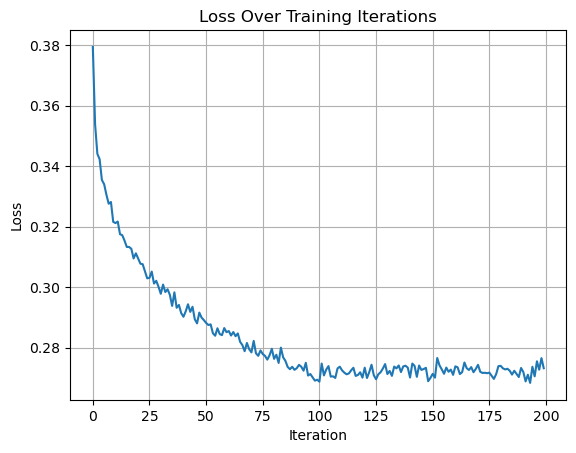

In [72]:
lossi_tensor = torch.tensor(lossi, device=device)
plt.figure()
plt.plot(lossi_tensor.view(-1, 1000).mean(1).cpu())
plt.title('Loss Over Training Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [78]:
g = torch.Generator(device=device).manual_seed(TORCH_GENERATOR_SEED + 15)
generate(model, 20, block_size, generator=g, device=device)

luxx.
luxden.
preslyn.
alaiyah.
hajeer.
kayena.
kaylani.
danuan.
kweljom.
kaylei.
kensley.
jacklel.
alyseha.
farhett.
avaes.
jordinn.
leslyn.
brandon.
diontario.
kahyari.
